#### Analyzing Neural Time Series Data
Python code for Chapter 26 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [42]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.signal import hilbert
from scipy.stats import norm
from mne.filter import filter_data

In [2]:
# Figure 26.1

# Load sample EEG dataset
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Names of the channels you want to synchronize
channel1 = 'P1'
channel2 = 'Pz'

# Create complex Morlet wavelet
center_freq = 5  # in Hz
srate = EEG['srate'][0, 0]
time = np.arange(-1, 1 + 1/srate, 1/srate)  # time for wavelet
wavelet = np.exp(2 * 1j * np.pi * center_freq * time) * np.exp(-time**2 / (2 * (4 / (2 * np.pi * center_freq))**2)) / center_freq
half_of_wavelet_size = (len(time) - 1) // 2

# FFT parameters
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0]
n_convolution = n_wavelet + n_data - 1

# FFT of wavelet
fft_wavelet = fft(wavelet, n_convolution)

# Initialize output time-frequency data
phase_data = np.zeros((2, n_data))
real_data = np.zeros((2, n_data))

# Find channel indices
chanidx = [EEG['chanlocs'][0]['labels']==channel1, EEG['chanlocs'][0]['labels']==channel2]

# Run convolution and extract filtered signal (real part) and phase
for chani in range(2):
    fft_data = fft(np.squeeze(EEG['data'][chanidx[chani], :, 0]), n_convolution)
    convolution_result_fft = ifft(fft_wavelet * fft_data, n_convolution) * np.sqrt(4 / (2 * np.pi * center_freq))
    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    
    # Collect real and phase data
    phase_data[chani, :] = np.angle(convolution_result_fft)
    real_data[chani, :] = np.real(convolution_result_fft)

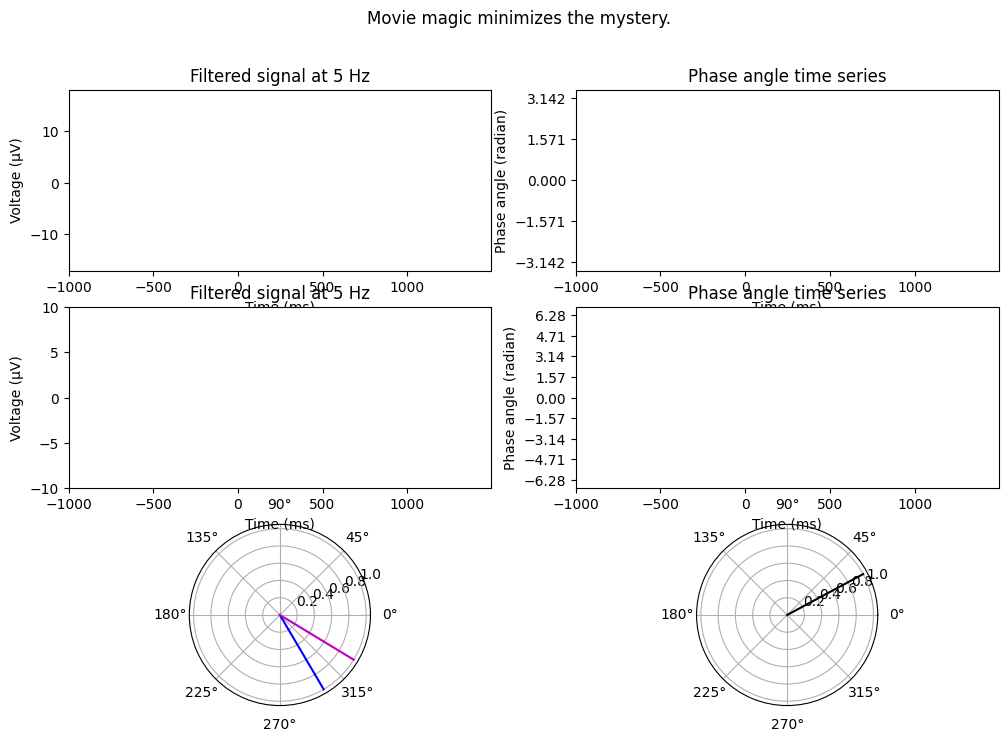

In [3]:
# Define the update function for the animation
def update(ti):
    # Update filtered signals
    filterplotH1.set_data(EEG['times'][0, :ti+1], real_data[0, :ti+1])
    filterplotH2.set_data(EEG['times'][0, :ti+1], real_data[1, :ti+1])

    # Update cartesian plot of phase angles
    phaseanglesH1.set_data(EEG['times'][0, :ti+1], phase_data[0, :ti+1])
    phaseanglesH2.set_data(EEG['times'][0, :ti+1], phase_data[1, :ti+1])

    # Update cartesian plot of phase angles differences
    phaseanglesDiffH1.set_data(EEG['times'][0, :ti+1], phase_data[0, :ti+1] - phase_data[1, :ti+1])
    filterplotDiffH1.set_data(EEG['times'][0, :ti+1], real_data[0, :ti+1] - real_data[1, :ti+1])

    # Update polar plot of phase angles
    ax1.clear()
    ax1.plot(np.tile(phase_data[0, :ti+1], 2), np.tile([0, 1], ti+1), 'b')
    ax1.plot(np.tile(phase_data[1, :ti+1], 2), np.tile([0, 1], ti+1), 'm')

    # Update polar plot of phase angle differences
    ax2.clear()
    ax2.plot(np.tile(phase_data[1, :ti+1] - phase_data[0, :ti+1], 2), np.tile([0, 1], ti+1), 'k')

    return filterplotH1, filterplotH2, phaseanglesH1, phaseanglesH2, phaseanglesDiffH1, filterplotDiffH1, ax1, ax2

# Create figure and axes
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[2, 0], polar=True)
ax2 = fig.add_subplot(gs[2, 1], polar=True)
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
plt.suptitle('Movie magic minimizes the mystery.')

# Initial plot setup
filterplotH1, = ax3.plot(EEG['times'][0], real_data[0, :], 'b')
filterplotH2, = ax3.plot(EEG['times'][0], real_data[1, :], 'm')
ax3.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax3.set_ylim([real_data.min(), real_data.max()])
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Voltage (μV)')
ax3.set_title(f'Filtered signal at {center_freq} Hz')

phaseanglesH1, = ax4.plot(EEG['times'][0], phase_data[0, :], 'b')
phaseanglesH2, = ax4.plot(EEG['times'][0], phase_data[1, :], 'm')
ax4.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax4.set_ylim([-np.pi * 1.1, np.pi * 1.1])
ax4.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Phase angle (radian)')
ax4.set_title('Phase angle time series')

filterplotDiffH1, = ax5.plot(EEG['times'][0], real_data[0, :] - real_data[1, :], 'b')
ax5.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax5.set_ylim([-10, 10])
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Voltage (μV)')
ax5.set_title(f'Filtered signal at {center_freq} Hz')

phaseanglesDiffH1, = ax6.plot(EEG['times'][0], phase_data[0, :] - phase_data[1, :], 'b')
ax6.set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
ax6.set_ylim([-np.pi * 2.2, np.pi * 2.2])
ax6.set_yticks([-2*np.pi, -3*np.pi/2, -np.pi, -np.pi/2, 0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax6.set_xlabel('Time (ms)')
ax6.set_ylabel('Phase angle (radian)')
ax6.set_title('Phase angle time series')

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, EEG['pnts'][0][0], 10), interval=100, blit=False)

# Display the animation in the Jupyter notebook
HTML(ani.to_html5_video())

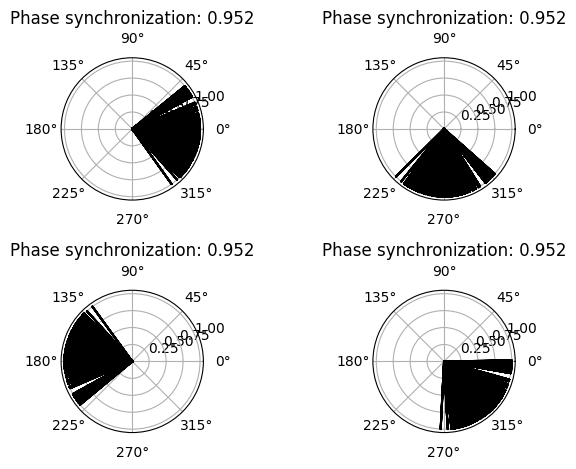

In [4]:
# Figure 26.2
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True))

# Plot phase synchronization for the original data
axs[0, 0].plot(np.tile(phase_data[1, :] - phase_data[0, :], 2), np.tile([0, 1], n_data), 'k')
axs[0, 0].set_title('Phase synchronization: {:.3f}'.format(np.abs(np.mean(np.exp(1j * (phase_data[1, :] - phase_data[0, :]))))))

# Generate new phase data with random phase offsets and plot
for i in range(1, 4):
    new_phase_data = phase_data.copy()
    new_phase_data[0, :] += np.random.rand() * np.pi  # add random phase offset
    axs[i // 2, i % 2].plot(np.tile(new_phase_data[1, :] - new_phase_data[0, :], 2), np.tile([0, 1], n_data), 'k')
    axs[i // 2, i % 2].set_title('Phase synchronization: {:.3f}'.format(np.abs(np.mean(np.exp(1j * (new_phase_data[1, :] - new_phase_data[0, :]))))))

plt.tight_layout()
plt.show()

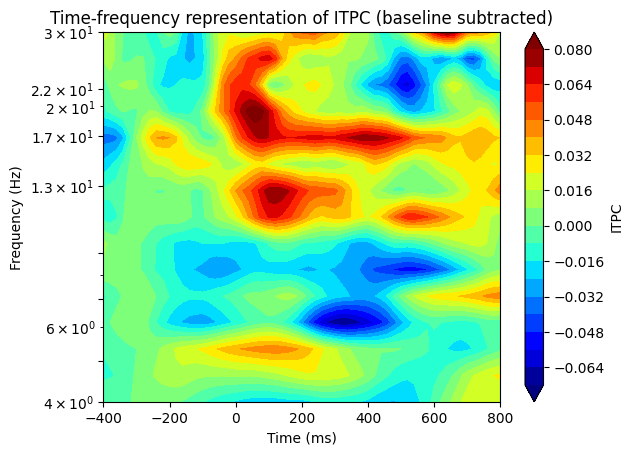

In [14]:
# Figure 26.3

# Define channels and frequencies
channel1 = 'Fz'
channel2 = 'O1'
freqs2use = np.logspace(np.log10(4), np.log10(30), 15)  # 4-30 Hz in 15 steps
times2save = np.arange(-400, 801, 20)  # Time points to save
timewindow = np.linspace(1.5, 3, len(freqs2use))  # Number of cycles on either end of the center point
baselinetm = [-400, -200]

# Wavelet and FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_wavelet = (len(time) - 1) // 2
num_cycles = np.logspace(np.log10(4), np.log10(8), len(freqs2use))
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# Time in indices
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])
baselineidx = np.array([np.argmin(np.abs(times2save - bt)) for bt in baselinetm])

# Find channel indices
chanidx = [EEG['chanlocs'][0]['labels']==channel1, EEG['chanlocs'][0]['labels']==channel2]

# Initialize ISPC matrix
ispc = np.zeros((len(freqs2use), len(times2save)))
ps = np.zeros((len(freqs2use), len(times2save)))

# Data FFTs
data_fft1 = fft(EEG['data'][chanidx[0], :, :].flatten('F'), n_convolution)
data_fft2 = fft(EEG['data'][chanidx[1], :, :].flatten('F'), n_convolution)

# Define time window in indices for each frequency
time_window_idx = np.round((1000 / freqs2use) * timewindow / (1000 / EEG['srate'][0][0])).astype(int)

# Loop over frequencies
for fi, freq in enumerate(freqs2use):
    
    # Create wavelet and take FFT
    s = num_cycles[fi] / (2 * np.pi * freq)
    wavelet_fft = fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time**2 / (2 * (s**2))), n_convolution)
    
    # Phase angles from channel 1 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig1 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))
    
    # Phase angles from channel 2 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig2 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))
    
    # Phase angle differences
    phase_diffs = phase_sig1 - phase_sig2

    ps[fi, :] = np.abs(np.mean(np.exp(1j * phase_diffs[times2saveidx, :]), axis=1))
    
    # Compute ITPC over trials within the time window
    for ti, time_idx in enumerate(times2saveidx):
        time_window_start = max(time_idx - time_window_idx[fi], 0)
        time_window_end = min(time_idx + time_window_idx[fi], n_data)
        ispc[fi, ti] = np.abs(np.mean(np.exp(1j * phase_diffs[time_window_start:time_window_end, :]), axis=0)).mean()

# Baseline subtraction
ispc = ispc - np.mean(ispc[:, baselineidx[0]:baselineidx[1]], axis=1)[:, None]

# Plotting
plt.figure()
plt.contourf(times2save, freqs2use, ispc, 20, cmap='jet', extend='both')
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
plt.colorbar(label='ITPC')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency representation of ITPC (baseline subtracted)')
plt.show()

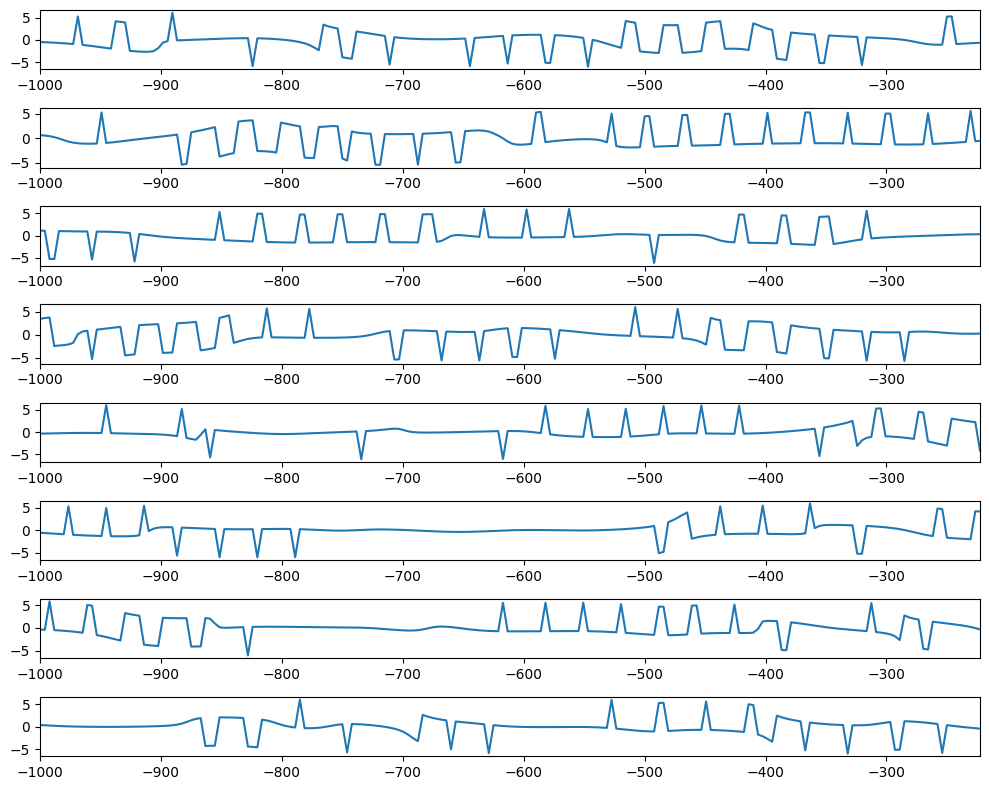

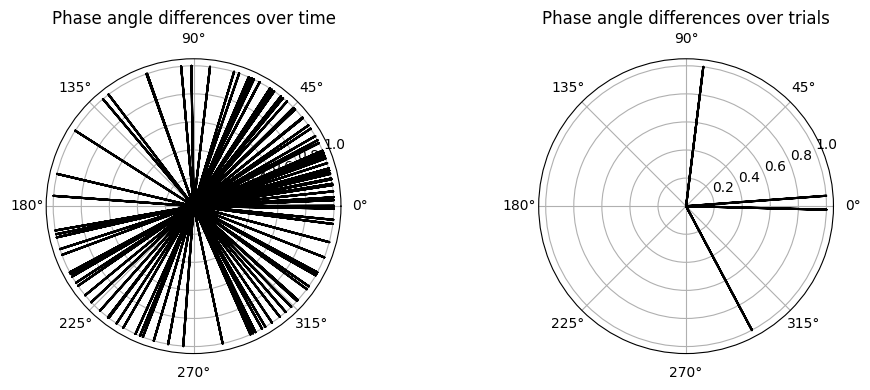

In [15]:
# Figure 26.4
plt.figure(figsize=(10, 8))

# Plot phase differences over time for the first 8 trials
for i in range(8):
    plt.subplot(8, 1, i + 1)
    plt.plot(EEG['times'][0][:200], phase_sig1[:200, i] - phase_sig2[:200, i])
    plt.xlim(EEG['times'][0][0], EEG['times'][0][199])

plt.tight_layout()
plt.show()

# Plot phase angle differences over time for the first trial in polar coordinates
plt.figure(figsize=(10, 4))
plt.subplot(121, projection='polar')
plt.plot(np.tile(phase_sig1[:200, 0] - phase_sig2[:200, 0], 2), np.tile([0, 1], 200), 'k')
plt.title('Phase angle differences over time')

# Plot phase angle differences over trials at a specific time point in polar coordinates
plt.subplot(122, projection='polar')
plt.plot(np.tile(phase_sig1[100, :8] - phase_sig2[100, :8], 2), np.tile([0, 1], 8), 'k')
plt.title('Phase angle differences over trials')

plt.tight_layout()
plt.show()

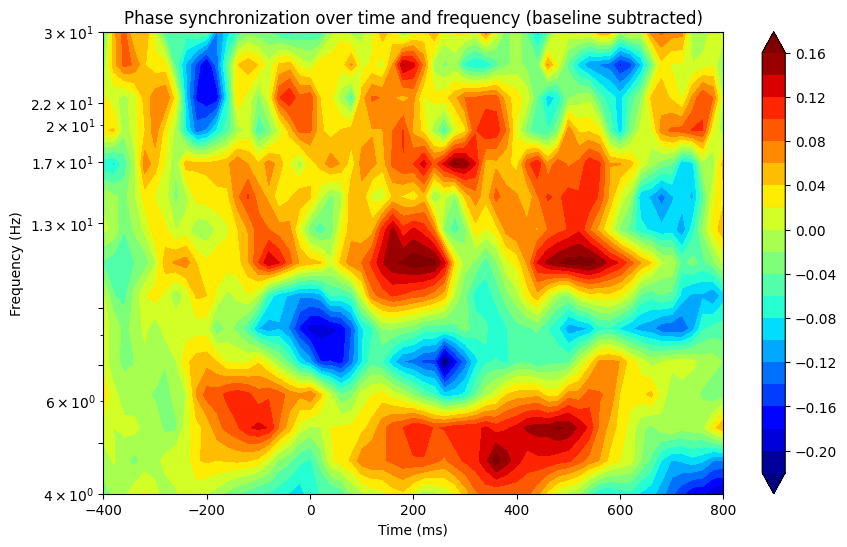

In [17]:
# Figure 26.5
plt.figure(figsize=(10, 6))
# Baseline subtraction
ps_baseline_subtracted = ps - np.mean(ps[:, baselineidx[0]:baselineidx[1]], axis=1, keepdims=True)
# Plotting
plt.contourf(times2save, freqs2use, ps_baseline_subtracted, 20, cmap='jet', extend='both')
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.title('Phase synchronization over time and frequency (baseline subtracted)')
plt.show()

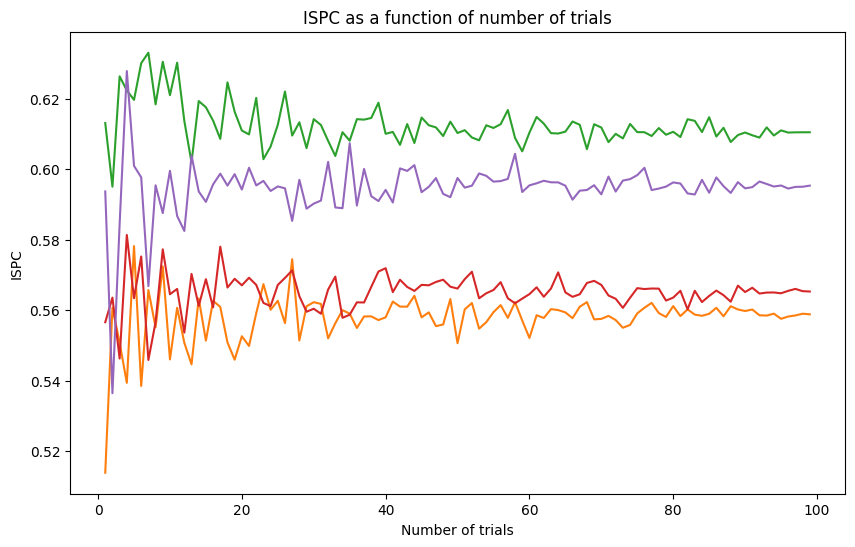

In [27]:
# Figure 26.6

# Time to use for analysis
time2use = 300  # ms
niterations = 50  # Number of iterations for random sampling

# Initialize
ispcByNandF = np.zeros((len(freqs2use), EEG['trials'][0][0]))
time2useidx = np.argmin(np.abs(times2save - time2use))

# Data FFTs (already computed in previous code for Figure 26.3)
# data_fft1 and data_fft2

for fi, freq in enumerate(freqs2use):
    
    # Create wavelet and take FFT
    s = num_cycles[fi] / (2 * np.pi * freq)
    wavelet_fft = fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time**2 / (2 * (s**2))), n_convolution)
    
    # Phase angles from channel 1 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig1 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))
    
    # Phase angles from channel 2 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    phase_sig2 = np.angle(np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F'))
    
    # Phase angle differences
    phase_diffs = phase_sig1 - phase_sig2
    
    # Compute time window in indices for this frequency
    time_window_idx = round((1000 / freq) * timewindow[fi] / (1000 / EEG['srate'][0][0]))
    
    # Compute ISPC for different numbers of trials
    for n in range(1, EEG['trials'][0][0] + 1):
        # Multiple iterations to select different random sets of trials
        for iteri in range(niterations):
            trials2use = np.random.choice(EEG['trials'][0][0], n, replace=False)
            # Ensure trials2use is used as an integer index array
            trials2use = trials2use.astype(int)
            # Correctly index phase_diffs with trials2use
            ispcByNandF[fi, n - 1] += np.mean(np.abs(np.mean(np.exp(1j * phase_diffs[time2useidx - time_window_idx:time2useidx + time_window_idx][:, trials2use]), axis=0)))

# Normalize by number of iterations
ispcByNandF /= niterations

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, EEG['trials'][0][0] + 1), ispcByNandF.T)
plt.xlabel('Number of trials')
plt.ylabel('ISPC')
plt.title('ISPC as a function of number of trials')
plt.show()

Setting up band-pass filter from 10 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 339 samples (1.324 s)

Setting up band-pass filter from 10 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- 

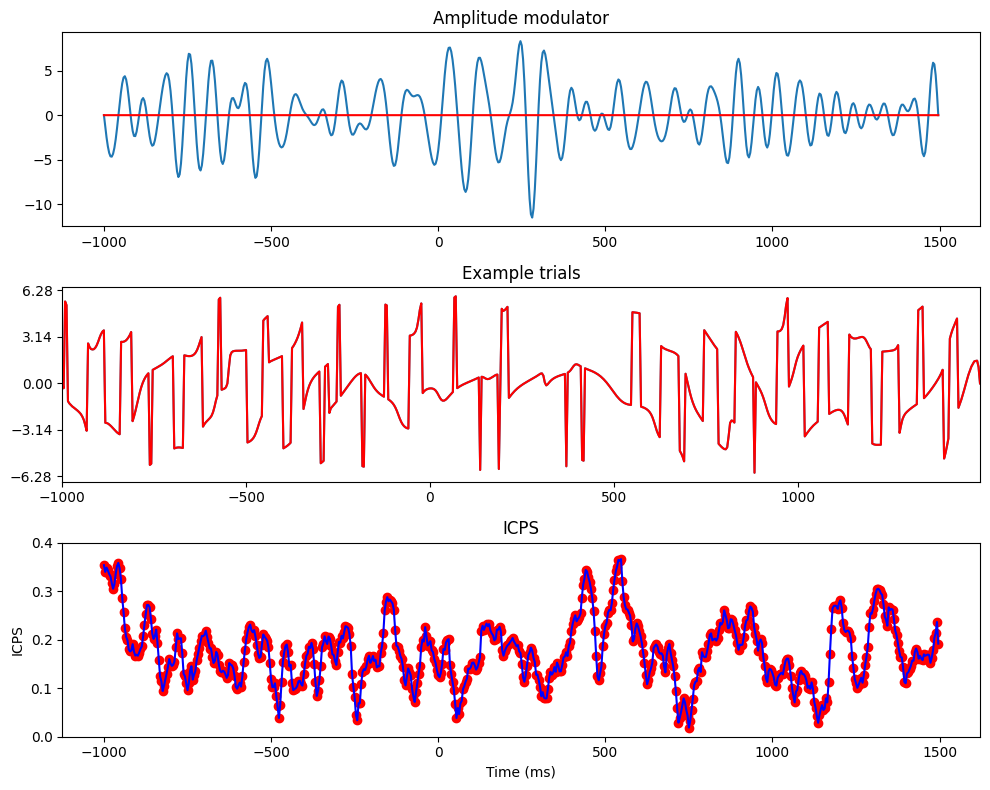

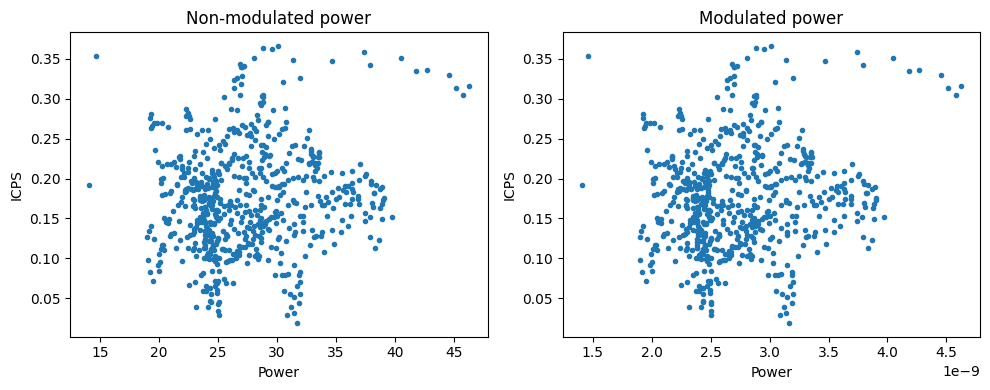

In [32]:
# Figure 26.7

# Initialize
data4test = np.zeros((2, EEG['pnts'][0][0], EEG['trials'][0][0]))
data4power = np.zeros((2, EEG['pnts'][0][0], EEG['trials'][0][0]))

amp_mod = 0.00001

for triali in range(EEG['trials'][0][0]):
    # Each trial is a random channel and trial
    trialdata1 = EEG['data'][chanidx[0], :, triali]
    trialdata2 = EEG['data'][chanidx[1], :, triali]
    
    # Band-pass filtered data
    trialdata1 = filter_data(trialdata1.astype(float), EEG['srate'][0][0], 10, 20)
    trialdata2 = filter_data(trialdata2.astype(float), EEG['srate'][0][0], 10, 20)
    
    # Phase angle differences, with and without amplitude dampening
    data4test[0, :, triali] = np.angle(hilbert(trialdata1)) - np.angle(hilbert(trialdata2))
    data4test[1, :, triali] = np.angle(hilbert(trialdata1)) - np.angle(hilbert(trialdata2 * amp_mod))
    
    data4power[0, :, triali] = np.abs(hilbert(trialdata2))**2
    data4power[1, :, triali] = np.abs(hilbert(trialdata2 * amp_mod))**2

# Compute ITPC
ispc_nomod = np.abs(np.mean(np.exp(1j * data4test[0, :, :]), axis=1))
ispc_mod = np.abs(np.mean(np.exp(1j * data4test[1, :, :]), axis=1))

# Compute power
power = np.mean(data4power, axis=2)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Amplitude modulator
axs[0].plot(EEG['times'][0], trialdata2[0, :])
axs[0].plot(EEG['times'][0], trialdata2[0, :] * amp_mod, 'r')
axs[0].set_title('Amplitude modulator')

# Example trials
axs[1].plot(EEG['times'][0], data4test[0, :, 10])
axs[1].plot(EEG['times'][0], data4test[1, :, 10], 'r')
axs[1].set_xlim([EEG['times'][0][0], EEG['times'][0][-1]])
axs[1].set_yticks([-2 * np.pi, -np.pi, 0, np.pi, 2 * np.pi])
axs[1].set_title('Example trials')

# ICPS
axs[2].plot(EEG['times'][0], ispc_mod, 'ro')
axs[2].plot(EEG['times'][0], ispc_nomod, 'b')
axs[2].set_ylim([0, 0.4])
axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('ICPS')
axs[2].set_title('ICPS')

plt.tight_layout()
plt.show()

# Power vs. ICPS
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Non-modulated power
axs[0].plot(power[0, :], ispc_nomod, '.')
axs[0].set_xlabel('Power')
axs[0].set_ylabel('ICPS')
axs[0].set_title('Non-modulated power')

# Modulated power
axs[1].plot(power[1, :], ispc_mod, '.')
axs[1].set_xlabel('Power')
axs[1].set_ylabel('ICPS')
axs[1].set_title('Modulated power')

plt.tight_layout()
plt.show()

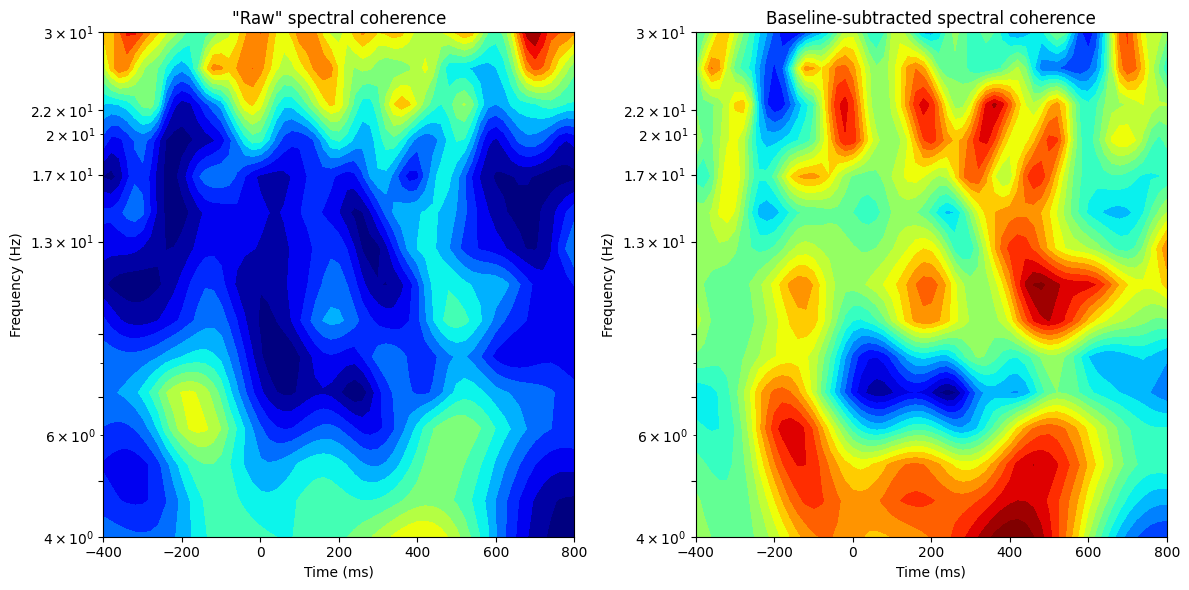

In [34]:
# Figure 26.8

# Select channels
channel1 = 'Fz'
channel2 = 'O1'

# Wavelet and FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_wavelet = (len(time) - 1) // 2
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# Find channel indices
chanidx = [EEG['chanlocs'][0]['labels']==channel1, EEG['chanlocs'][0]['labels']==channel2]

# Data FFTs
data_fft1 = fft(EEG['data'][chanidx[0], :, :].flatten('F'), n_convolution)
data_fft2 = fft(EEG['data'][chanidx[1], :, :].flatten('F'), n_convolution)

# Initialize spectral coherence matrix
spectcoher = np.zeros((len(freqs2use), len(times2save)))

# Loop over frequencies
for fi, freq in enumerate(freqs2use):
    
    # Create wavelet and take FFT
    s = num_cycles[fi] / (2 * np.pi * freq)
    wavelet_fft = fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time**2 / (2 * (s**2))), n_convolution)
    
    # Phase angles from channel 1 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    sig1 = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Phase angles from channel 2 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    sig2 = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Compute power and cross-spectral power
    spec1 = np.mean(sig1 * np.conj(sig1), axis=1)
    spec2 = np.mean(sig2 * np.conj(sig2), axis=1)
    specX = np.abs(np.mean(sig1 * np.conj(sig2), axis=1))**2
    
    # Compute spectral coherence, using only requested time points
    spectcoher[fi, :] = np.abs(specX[times2saveidx]) / (np.abs(spec1[times2saveidx]) * np.abs(spec2[times2saveidx]))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# "Raw" spectral coherence
axs[0].contourf(times2save, freqs2use, spectcoher, 20, cmap='jet', extend='both')
axs[0].set_yscale('log')
axs[0].set_yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('"Raw" spectral coherence')

# Baseline-subtracted spectral coherence
baselineidx = np.array([np.argmin(np.abs(times2save - bt)) for bt in baselinetm])
spectcoher_baseline_subtracted = spectcoher - np.mean(spectcoher[:, baselineidx[0]:baselineidx[1]], axis=1)[:, None]
axs[1].contourf(times2save, freqs2use, spectcoher_baseline_subtracted, 20, cmap='jet', extend='both')
axs[1].set_yscale('log')
axs[1].set_yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Frequency (Hz)')
axs[1].set_title('Baseline-subtracted spectral coherence')

plt.tight_layout()
plt.show()

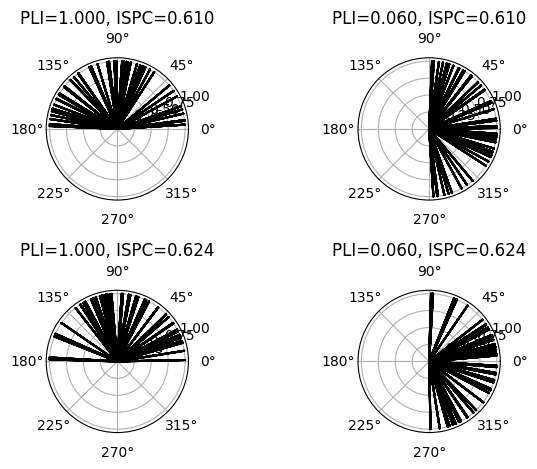

In [37]:
# Figure 26.9

# Number of "trials"
n = 100

fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True))

# Generate random phases and compute PLI and ISPC
for i, ax in enumerate(axs.flatten()):
    # Generate random phases
    if i % 2 == 0:
        phases = np.random.rand(n) * np.pi
    else:
        phases = phases - np.pi / 2
    
    # Plot phases in polar coordinates
    ax.plot(np.tile(phases, 2), np.tile([0, 1], n), 'k')
    
    # Compute PLI and ISPC
    pli = np.abs(np.mean(np.sign(np.sin(phases))))
    ispc = np.abs(np.mean(np.exp(1j * phases)))
    
    # Set title with PLI and ISPC values
    ax.set_title(f'PLI={pli:.3f}, ISPC={ispc:.3f}')

plt.tight_layout()
plt.show()

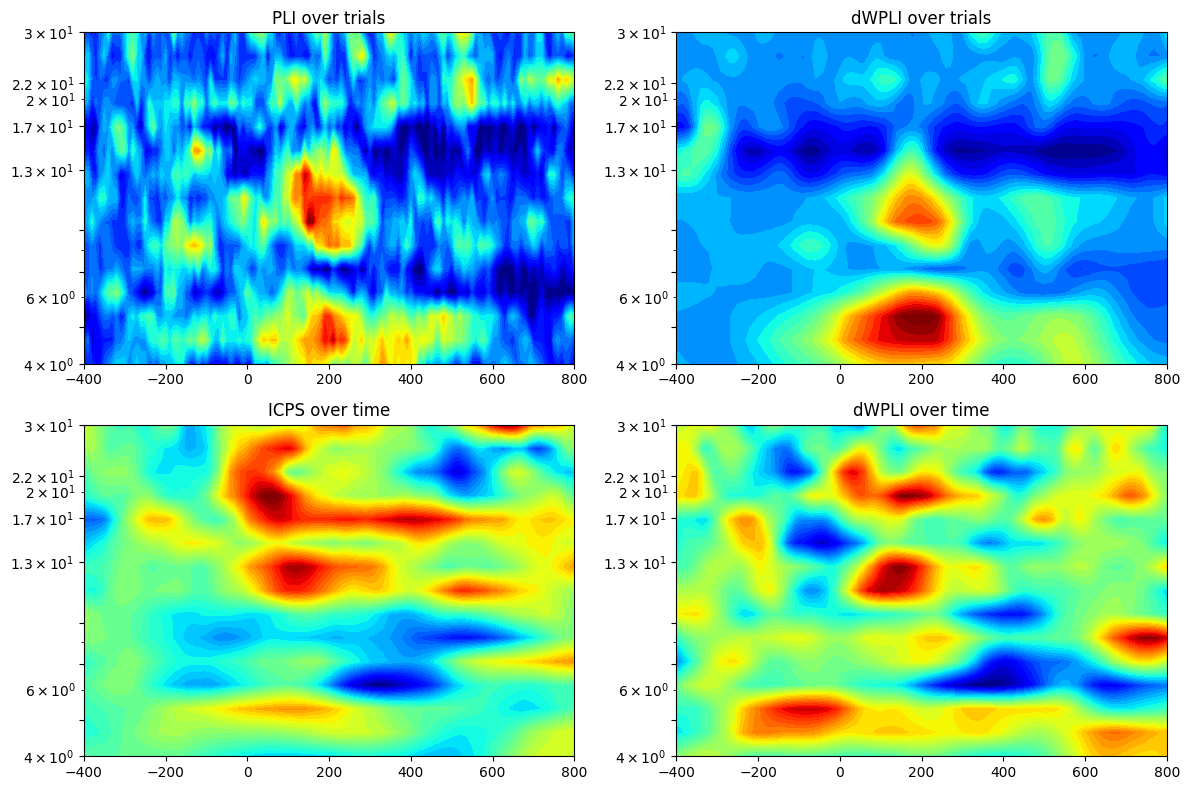

In [38]:
# Figure 26.10

# Select channels
channel1 = 'Fz'
channel2 = 'O1'

# Specify some time-frequency parameters
freqs2use = np.logspace(np.log10(4), np.log10(30), 15)  # 4-30 Hz in 15 steps
times2save = np.arange(-400, 801, 10)  # Time points to save
timewindow = np.linspace(1.5, 3, len(freqs2use))  # Number of cycles on either end of the center point
baselinetm = [-400, -200]

# Wavelet and FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
half_wavelet = (len(time) - 1) // 2
num_cycles = np.logspace(np.log10(4), np.log10(8), len(freqs2use))
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1

# Time in indices
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])
baselineidxF = np.array([np.argmin(np.abs(EEG['times'][0] - bt)) for bt in baselinetm])  # For the full temporal resolution data
baselineidx = np.array([np.argmin(np.abs(times2save - bt)) for bt in baselinetm])  # For the temporally downsampled data

# Find channel indices
chanidx = [EEG['chanlocs'][0]['labels']==channel1, EEG['chanlocs'][0]['labels']==channel2]

# Data FFTs
data_fft1 = fft(EEG['data'][chanidx[0], :, :].flatten('F'), n_convolution)
data_fft2 = fft(EEG['data'][chanidx[1], :, :].flatten('F'), n_convolution)

# Initialize
ispc = np.zeros((len(freqs2use), EEG['pnts'][0][0]))
pli = np.zeros((len(freqs2use), EEG['pnts'][0][0]))
wpli = np.zeros((len(freqs2use), EEG['pnts'][0][0]))
dwpli = np.zeros((len(freqs2use), EEG['pnts'][0][0]))
dwpli_t = np.zeros((len(freqs2use), len(times2save)))
ispc_t = np.zeros((len(freqs2use), len(times2save)))

# Loop over frequencies
for fi, freq in enumerate(freqs2use):
    
    # Create wavelet and take FFT
    s = num_cycles[fi] / (2 * np.pi * freq)
    wavelet_fft = fft(np.exp(2 * 1j * np.pi * freq * time) * np.exp(-time**2 / (2 * (s**2))), n_convolution)
    
    # Phase angles from channel 1 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    sig1 = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Phase angles from channel 2 via convolution
    convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
    convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
    sig2 = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Cross-spectral density
    cdd = sig1 * np.conj(sig2)
    
    # ISPC
    ispc[fi, :] = np.abs(np.mean(np.exp(1j * np.angle(cdd)), axis=1))
    
    # Take imaginary part of signal only
    cdi = np.imag(cdd)
    
    # Phase-lag index
    pli[fi, :] = np.abs(np.mean(np.sign(cdi), axis=1))
    
    # Weighted phase-lag index
    wpli[fi, :] = np.abs(np.mean(np.abs(cdi) * np.sign(cdi), axis=1)) / np.mean(np.abs(cdi), axis=1)
    
    # Debiased weighted phase-lag index
    imagsum = np.sum(cdi, axis=1)
    imagsumW = np.sum(np.abs(cdi), axis=1)
    debiasfactor = np.sum(cdi**2, axis=1)
    dwpli[fi, :] = (imagsum**2 - debiasfactor) / (imagsumW**2 - debiasfactor)
    
    # Compute time window in indices for this frequency
    time_window_idx = round((1000 / freq) * timewindow[fi] / (1000 / EEG['srate'][0][0]))
    
    for ti, t in enumerate(times2save):
        # Debiased weighted phase-lag index over time
        imagsum = np.sum(cdi[times2saveidx[ti] - time_window_idx:times2saveidx[ti] + time_window_idx, :], axis=0)
        imagsumW = np.sum(np.abs(cdi[times2saveidx[ti] - time_window_idx:times2saveidx[ti] + time_window_idx, :]), axis=0)
        debiasfactor = np.sum(cdi[times2saveidx[ti] - time_window_idx:times2saveidx[ti] + time_window_idx, :]**2, axis=0)
        dwpli_t[fi, ti] = np.mean((imagsum**2 - debiasfactor) / (imagsumW**2 - debiasfactor))
        
        # Compute phase synchronization
        phasesynch = np.abs(np.mean(np.exp(1j * np.angle(cdd[times2saveidx[ti] - time_window_idx:times2saveidx[ti] + time_window_idx, :])), axis=0))
        ispc_t[fi, ti] = np.mean(phasesynch)

# Baseline subtraction from all measures
ispc = ispc - np.mean(ispc[:, baselineidxF[0]:baselineidxF[1]], axis=1)[:, None]
ispc_t = ispc_t - np.mean(ispc_t[:, baselineidx[0]:baselineidx[1]], axis=1)[:, None]
pli = pli - np.mean(pli[:, baselineidxF[0]:baselineidxF[1]], axis=1)[:, None]
dwpli = dwpli - np.mean(dwpli[:, baselineidxF[0]:baselineidxF[1]], axis=1)[:, None]
dwpli_t = dwpli_t - np.mean(dwpli_t[:, baselineidx[0]:baselineidx[1]], axis=1)[:, None]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# PLI over trials
axs[0, 0].contourf(times2save, freqs2use, pli[:, times2saveidx], 40, cmap='jet', extend='both')
axs[0, 0].set_yscale('log')
axs[0, 0].set_yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
axs[0, 0].set_title('PLI over trials')

# dWPLI over trials
axs[0, 1].contourf(times2save, freqs2use, dwpli[:, times2saveidx], 40, cmap='jet', extend='both')
axs[0, 1].set_yscale('log')
axs[0, 1].set_yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
axs[0, 1].set_title('dWPLI over trials')

# ICPS over time
axs[1, 0].contourf(times2save, freqs2use, ispc_t, 40, cmap='jet', extend='both')
axs[1, 0].set_yscale('log')
axs[1, 0].set_yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
axs[1, 0].set_title('ICPS over time')

# dWPLI over time
axs[1, 1].contourf(times2save, freqs2use, dwpli_t, 40, cmap='jet', extend='both')
axs[1, 1].set_yscale('log')
axs[1, 1].set_yticks(np.round(np.logspace(np.log10(freqs2use[0]), np.log10(freqs2use[-1]), 8)))
axs[1, 1].set_title('dWPLI over time')

plt.tight_layout()
plt.show()

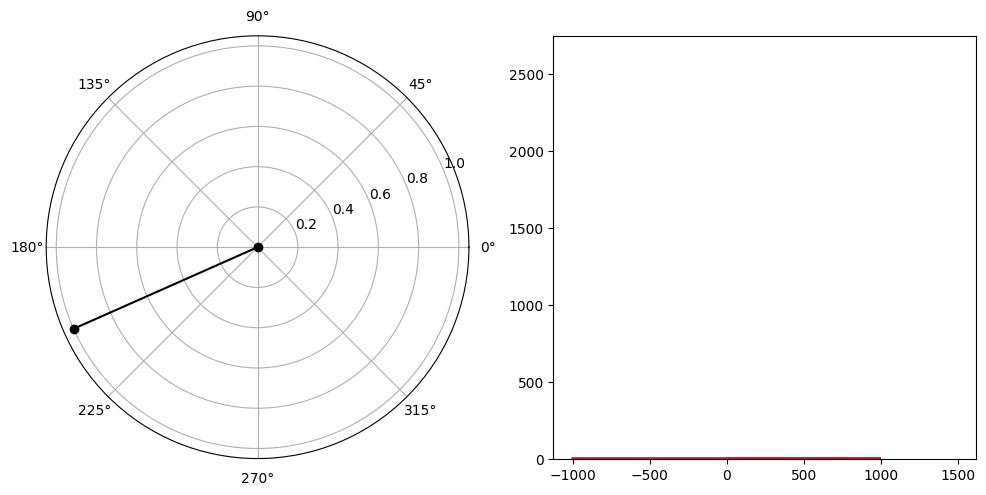

In [40]:
# Figure 26.11

# Trial to plot
trial2plot = 10  # Any trial between 1 and 99 (book uses trial 10)
center_freq = 4.6  # Hz (book uses 4.6)

# Create wavelet and take FFT
s = 4.5 / (2 * np.pi * center_freq)
wavelet_fft = fft(np.exp(2 * 1j * np.pi * center_freq * time) * np.exp(-time**2 / (2 * (s**2))), n_convolution)

# Phase angles from channel 1 via convolution
convolution_result_fft = ifft(wavelet_fft * data_fft1, n_convolution)
convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
sig1 = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Phase angles from channel 2 via convolution
convolution_result_fft = ifft(wavelet_fft * data_fft2, n_convolution)
convolution_result_fft = convolution_result_fft[half_wavelet:-half_wavelet]
sig2 = np.reshape(convolution_result_fft, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Cross-spectral density
xsd = sig1 * np.conj(sig2)
xsdi = np.imag(xsd)

dwpli = np.zeros(EEG['pnts'][0][0])
ispc = np.zeros(EEG['pnts'][0][0])

# Animation start and stop times
animate_start = np.argmin(np.abs(EEG['times'][0] - 0))
animate_stop = np.argmin(np.abs(EEG['times'][0] - 1000))

# Time window in indices
time_window_idx = round(100 * timewindow[1] / (1000 / EEG['srate'][0][0]))

# Initialize figure for animation with polar subplot
fig = plt.figure(figsize=(12, 6))
ax_polar = plt.subplot(121, polar=True)
ax_line = plt.subplot(122)

# Initial plot setup
hpol = ax_polar.plot([0, np.angle(xsd[animate_start, trial2plot])], [0, 1], 'k-o')[0]
hplo1, = ax_line.plot(EEG['times'][0], ispc, 'b')
hplo2, = ax_line.plot(EEG['times'][0], dwpli, 'r')

# Function to update the animation
def update(idx):
    # Update angles
    hpol.set_data([0, np.angle(xsd[idx, trial2plot])], [0, 1])
    
    # Compute ICPS and dWPLI
    ispc[idx] = np.abs(np.mean(np.exp(1j * np.angle(xsd[idx:idx + time_window_idx, trial2plot])), axis=0))
    
    imagsum = np.sum(xsdi[idx:idx + time_window_idx, trial2plot])
    imagsumW = np.sum(np.abs(xsdi[idx:idx + time_window_idx, trial2plot]))
    debiasfactor = np.sum(xsdi[idx:idx + time_window_idx, trial2plot]**2)
    dwpli[idx] = (imagsum**2 - debiasfactor) / (imagsumW**2 - debiasfactor)
    
    # Update plots
    hplo1.set_data(EEG['times'][0][:idx + 1], ispc[:idx + 1])
    hplo2.set_data(EEG['times'][0][:idx + 1], dwpli[:idx + 1])
    ax_line.set_xlim(EEG['times'][0][animate_start], EEG['times'][0][animate_stop])
    ax_line.set_ylim(-0.1, 1.1)
    ax_line.axis('square')
    
    return hpol, hplo1, hplo2

# Create the animation
ani = FuncAnimation(fig, update, frames=range(animate_start, animate_stop), interval=100, blit=True)

# Display the animation in the Jupyter notebook
HTML(ani.to_html5_video())

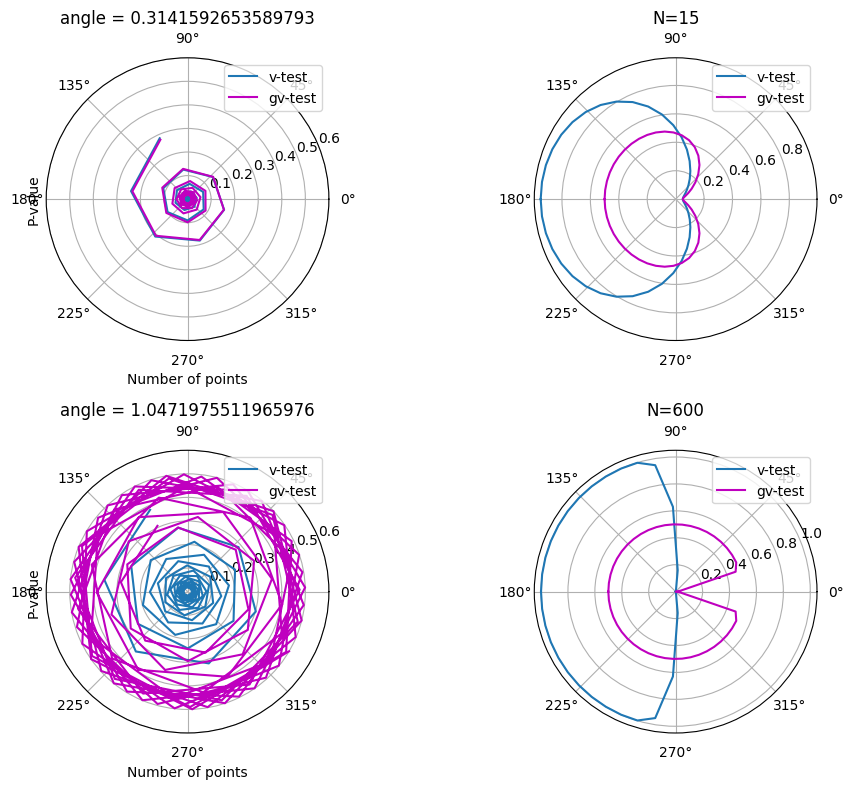

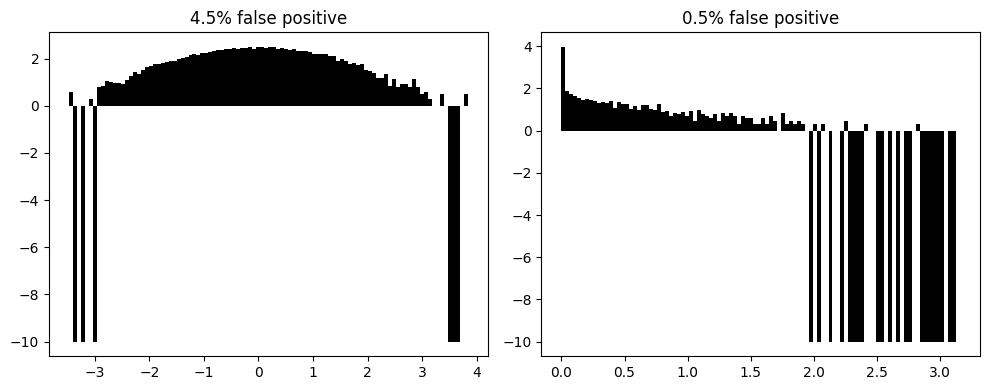

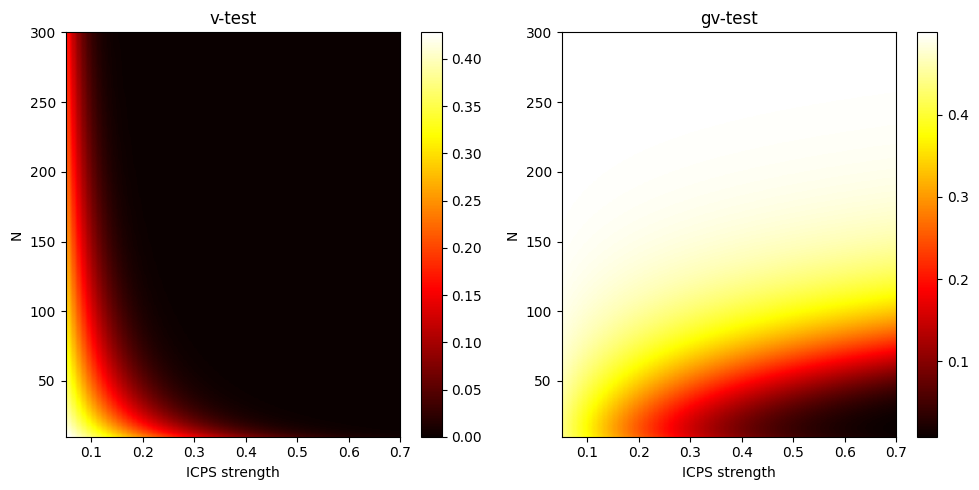

In [48]:
# Figure 26.12

# This figure is generated in the code below.

# Figure 26.13

# Define inline functions for v-test and gv-test
def vtest(icpcmag, n, val):
    return n * icpcmag * np.cos(val) * np.sqrt(2.0 / n)

def gvtest(icpcmag, n, val):
    return n * (icpcmag * np.exp((-(val)**2) / (4.0 * np.pi / n)) * (np.sqrt(2.0 / n)))

# Figure setup with polar subplots created upfront
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw=dict(polar=True))

# Number of data points
n = np.arange(2, 101)

# Plot p-values for v-test and gv-test for different angles
angles = [np.pi/10, np.pi/3]
for i, angle in enumerate(angles):
    p_vtest = 1 - norm.cdf(vtest(0.3, n, angle))
    p_gvtest = 1 - norm.cdf(gvtest(0.3, n, angle))
    
    axs[i, 0].plot(n, p_vtest, label='v-test')
    axs[i, 0].plot(n, p_gvtest, 'm', label='gv-test')
    axs[i, 0].legend()
    axs[i, 0].set_xlabel('Number of points')
    axs[i, 0].set_ylabel('P-value')
    axs[i, 0].set_ylim(0, 0.6)
    axs[i, 0].set_title(f'angle = {angle}')

# Plot p-values for different numbers of points on polar subplots
x = np.linspace(-np.pi, np.pi, 50)
n_values = [15, 600]
for i, n_val in enumerate(n_values):
    p_vtest = 1 - norm.cdf(vtest(0.3, n_val, x - 0))
    p_gvtest = 1 - norm.cdf(gvtest(0.3, n_val, x - 0))
    
    axs[i, 1].plot(x, p_vtest, label='v-test')
    axs[i, 1].plot(x, p_gvtest, 'm', label='gv-test')
    axs[i, 1].set_title(f'N={n_val}')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()

# Simulate data for false positive rates
numUsims = 10000
u = np.zeros((2, numUsims))

for i in range(numUsims):
    # Make some noise
    fake_phase_data = np.random.rand(2, EEG['pnts'][0][0]) * 2 * np.pi - np.pi
    
    # Compute ISPC
    ispc_mag = np.abs(np.mean(np.exp(1j * (np.diff(fake_phase_data, axis=0)))))
    ispc_phs = np.angle(np.mean(np.exp(1j * (np.diff(fake_phase_data, axis=0)))))
    
    # Compute statistics
    u[0, i] = vtest(ispc_mag, EEG['pnts'][0][0], ispc_phs - 0)
    u[1, i] = gvtest(ispc_mag, EEG['pnts'][0][0], ispc_phs - 0)

# Plot histograms of u-values
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i in range(2):
    y, x = np.histogram(u[i, :], bins=100)
    # Add a small constant (e.g., 1e-10) to avoid log of zero
    y_log = np.log10(y + 1e-10)
    axs[i].bar(x[:-1], y_log, width=np.diff(x), align='edge', color='k')
    false_pos_rate = 100 * np.sum((1 - norm.cdf(u[i, :])) < 0.05) / len(u[i, :])
    axs[i].set_title(f'{false_pos_rate:.1f}% false positive')

plt.tight_layout()
plt.show()

# Create a matrix of p-values for different combinations of ISPC strength and number of data points
nrange = np.arange(10, 301)
ispcrange = np.arange(0.05, 0.71, 0.01)
pvalmat = np.zeros((2, len(nrange), len(ispcrange)))

for ni, n_val in enumerate(nrange):
    for mi, m_val in enumerate(ispcrange):
        pvalmat[0, ni, mi] = 1 - norm.cdf(vtest(m_val, n_val, np.pi/5))
        pvalmat[1, ni, mi] = 1 - norm.cdf(gvtest(m_val, n_val, np.pi/5))

# Plotting the matrix of p-values
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, title in enumerate(['v-test', 'gv-test']):
    im = axs[i].imshow(pvalmat[i, :, :], extent=[ispcrange[0], ispcrange[-1], nrange[0], nrange[-1]], aspect='auto', origin='lower', cmap='hot')
    axs[i].set_xlabel('ICPS strength')
    axs[i].set_ylabel('N')
    axs[i].set_title(title)
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.show()